In [6]:
using Gurobi, StatsBase, CSV, DataFrames, JuMP, LinearAlgebra, Distributions, Random, GLMNet, Printf

In [7]:
data = CSV.read("final_df.csv", DataFrame);

In [8]:
price = data[!, "price"];
food_products = data[!, "food"];
foods = size(food_products, 1);
emissions = data[!, "emissions"];
calories = data[!, "calories"];
protein = data[!, "protein"]
total_fat = data[!, "total_fat"]
carbohydrate = data[!, "carbohydrate"]
fiber = data[!, "fiber"]
sugars = data[!, "sugars"]
saturated_fatty_acids = data[!, "saturated_fatty_acids"]
monounsaturated_fatty_acids = data[!, "monounsaturated_fatty_acids"]
polyunsaturated_fatty_acids = data[!, "polyunsaturated_fatty_acids"]
fatty_acids_total_trans = data[!, "fatty_acids_total_trans"];
vitamin_a = data[!, "vitamin_a"]
vitamin_b6 = data[!, "vitamin_b6"]
vitamin_b12 = data[!, "vitamin_b12"]
vitamin_c = data[!, "vitamin_c"]
vitamin_d = data[!, "vitamin_d"]
vitamin_e = data[!, "vitamin_e"]
vitamin_k = data[!, "vitamin_k"]
thiamin = data[!, "thiamin"]
riboflavin = data[!, "riboflavin"]
niacin = data[!, "niacin"]
folate = data[!, "folate"]
pantothenic_acid = data[!, "pantothenic_acid"]
calcium = data[!, "calcium"]
iron = data[!, "irom"]
magnesium = data[!, "magnesium"]
phosphorous = data[!, "phosphorous"]
potassium = data[!, "potassium"]
sodium = data[!, "sodium"]
zinc = data[!, "zink"]
copper = data[!, "copper"]
manganese = data[!, "manganese"]
selenium = data[!, "selenium"]
choline = data[!, "choline"]
lutein_zeaxanthin = data[!, "lutein_zeaxanthin"]
lucopene = data[!, "lucopene"]
carotene_beta = data[!, "carotene_beta"]
cryptoxanthin_beta = data[!, "cryptoxanthin_beta"]
tocopherol_alpha = data[!, "tocopherol_alpha"];
alanine = data[!, "alanine"]
arginine = data[!, "arginine"]
aspartic_acid = data[!, "aspartic_acid"]
cystine = data[!, "cystine"]
glutamic_acid = data[!, "glutamic_acid"]
glycine = data[!, "glycine"]
histidine = data[!, "histidine"]
hydroxyproline = data[!, "hydroxyproline"]
isoleucine = data[!, "isoleucine"]
leucine = data[!, "leucine"]
lysine = data[!, "lysine"]
methionine = data[!, "methionine"]
phenylalanine = data[!, "phenylalanine"]
proline = data[!, "proline"]
serine = data[!, "serine"]
threonine = data[!, "threonine"]
tryptophan = data[!, "tryptophan"]
tyrosine = data[!, "tyrosine"]
valine = data[!, "valine"];
water = data[!, "water"]
caffeine = data[!, "caffeine"]
theobromine = data[!, "theobromine"]
ash = data[!, "ash"]
alcohol = data[!, "alcohol"];

In [9]:
# Define all food groups
meats = ["Beef (beef herd)", "Beef (dairy herd)", "Lamb & Mutton", "Pork", "Chicken Meat", "Fish (farmed)", "Shrimps (farmed)"]
meat_inds = [findfirst(isequal(item), food_products) for item in meats]

animal = ["Beef (beef herd)", "Beef (dairy herd)", "Lamb & Mutton", "Pork", "Chicken Meat", "Milk", "Cheese", "Eggs", 
    "Fish (farmed)", "Shrimps (farmed)"]
animal_inds = [findfirst(isequal(item), food_products) for item in animal]

dairy = ["Milk", "Cheese"]
dairy_inds = [findfirst(isequal(item), food_products) for item in dairy]

gluten = ["Wheat & Rye (Bread)", "Barley (Beer)"]
gluten_inds = [findfirst(isequal(item), food_products) for item in gluten]

alcohol = ["Barley (Beer)", "Wine"];
alcohol_inds = [findfirst(isequal(item), food_products) for item in alcohol]

nuts = ["Nuts", "Peanuts"]
nuts_inds = [findfirst(isequal(item), food_products) for item in nuts]

caffeine = ["Coffee"]
caffeine_inds = [findfirst(isequal(item), food_products) for item in caffeine];

In [10]:
# Price sensitivity
lambda = 0.5;
# Big-M
M = 10000;

# Dietary preferences
z_veg = 0
z_vegan = 0
z_meat_low = 0
z_meat_med = 1
z_meat_high = 0

z_lactose = 1
z_gluten = 0
z_nuts = 0

z_alc = 1
z_caffeine = 0;

In [6]:
# Price sensitivity
lambda = 0.5;
# Big-M
M = 10000;

# Dietary preferences
z_veg = 0
z_vegan = 0
z_meat_low = 0
z_meat_med = 1
z_meat_high = 0

z_lactose = 1
z_gluten = 0
z_nuts = 0

z_alc = 1
z_caffeine = 0;
model = Model(Gurobi.Optimizer);
@variable(model, x[1:foods] >= 0);
# Dual objective function (minimize total carbon emissions and cost)
@objective(model, Min, (1 - lambda) * sum(emissions[i] * x[i] for i in 1:foods) 
    + lambda * sum(price[i] * x[i] for i in 1:foods));
@constraint(model, ingredient_limit[i=1:foods], x[i] <= 500);
@constraint(model, vegetarian_constraint[i in meat_inds], x[i] <= M * (1 - z_veg))
@constraint(model, vegan_constraint[i in animal_inds], x[i] <= M * (1 - z_vegan))
@constraint(model, lactose_constraint[i in dairy_inds], x[i] <= M * (1 - z_lactose))
@constraint(model, gluten_constraint[i in gluten_inds], x[i] <= M * (1 - z_gluten))
@constraint(model, nuts_constraint[i in nuts_inds], x[i] <= M * z_nuts)
@constraint(model, alcohol_constraint[i in alcohol_inds], x[i] >= 100 * z_alc)
@constraint(model, caffeine_constraint[i in caffeine_inds], x[i] <= M * z_caffeine)
@constraint(model, meat_low_constraint, sum(x[i] for i in meat_inds) >= 100 * z_meat_low)
@constraint(model, meat_med_constraint, sum(x[i] for i in meat_inds) >= 200 * z_meat_med)
@constraint(model, meat_high_constraint, sum(x[i] for i in meat_inds) >= 300 * z_meat_high);
@constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= 50)   # Protein minimum 50g
@constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= 78)       # Fat minimum 78g
@constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= 275); # Carbohydrate minimum 275g
@constraint(model, sum(calcium[i] * x[i] for i in 1:foods) >= 1300) # Calcium minimum 1300mg
@constraint(model, sum(iron[i] * x[i] for i in 1:foods) >= 18)      # Iron minimum 18mg
@constraint(model, sum(magnesium[i] * x[i] for i in 1:foods) >= 420) # Magnesium minimum 420mg
@constraint(model, sum(phosphorous[i] * x[i] for i in 1:foods) >= 1250) # Phosphorus minimum 1250mg
@constraint(model, sum(potassium[i] * x[i] for i in 1:foods) >= 4700) # Potassium minimum 4700mg
@constraint(model, sum(sodium[i] * x[i] for i in 1:foods) >= 2300)  # Sodium minimum 2300mg ***
@constraint(model, sum(zinc[i] * x[i] for i in 1:foods) >= 11)      # Zinc minimum 11mg
@constraint(model, sum(vitamin_a[i] * x[i] for i in 1:foods) >= 900) # Vitamin A minimum 900mcg RAE
@constraint(model, sum(vitamin_c[i] * x[i] for i in 1:foods) >= 90)  # Vitamin C minimum 90mg
@constraint(model, sum(vitamin_d[i] * x[i] for i in 1:foods) >= 20)  # Vitamin D minimum 20mcg
@constraint(model, sum(vitamin_e[i] * x[i] for i in 1:foods) >= 15)  # Vitamin E minimum 15mg alpha-tocopherol
@constraint(model, sum(vitamin_k[i] * x[i] for i in 1:foods) >= 120) # Vitamin K minimum 120mcg
@constraint(model, sum(riboflavin[i] * x[i] for i in 1:foods) >= 1.3) # Riboflavin minimum 1.3mg
@constraint(model, sum(niacin[i] * x[i] for i in 1:foods) >= 16)    # Niacin minimum 16mg NE
@constraint(model, sum(folate[i] * x[i] for i in 1:foods) >= 400)   # Folate minimum 400mcg DFE
@constraint(model, sum(vitamin_b12[i] * x[i] for i in 1:foods) >= 2.4) # Vitamin B12 minimum 2.4mcg
@constraint(model, sum(vitamin_b6[i] * x[i] for i in 1:foods) >= 1.7) # Vitamin B6 minimum 1.7mg
@constraint(model, sum(choline[i] * x[i] for i in 1:foods) >= 550);  # Choline minimum 550mg
# @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2500) # Calories maximum at 2500
@constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= 2000); # Calories minimum at 2000
optimize!(model)
# Check if the model has a solution
if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
    # Retrieve optimal values for decision variables
    optimal_diet = value.(x)
    # Retrieve the objective function value
    total_emissions_optimal = sum(optimal_diet[i] * emissions[i] for i in 1:foods)
    total_price_optimal = sum(optimal_diet[i] * price[i] for i in 1:foods)

    # Print the results
    println("Optimal diet: ", optimal_diet)
    println("\nTotal emissions: ", total_emissions_optimal)
    println("\nTotal price: ", total_price_optimal)
else
    println("No optimal solution found. Status: ", termination_status(model))
end
# Extract the 'Food product' column from the DataFrame
food_product = data[!, "food"]

# Check if the model has a solution
if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
    # Retrieve optimal values for decision variables
    optimal_diet = value.(x)
    # Retrieve the objective function value
    total_emissions = objective_value(model)

    # Print the results
    println("Optimal diet (grams of food):\n")
    for i in 1:length(optimal_diet)
        if optimal_diet[i] > 0
            println(food_product[i], ": ", optimal_diet[i])
        end
    end
    println("\nTotal emissions (kg CO2): ", total_emissions)
else
    println("No optimal solution found. Status: ", termination_status(model))
end

# Calculate total nutrients in the optimized diet

total_nutrients = Dict(
    "calories" => sum(calories[i] * optimal_diet[i] for i in 1:foods),
    "protein" => sum(protein[i] * optimal_diet[i] for i in 1:foods),
    "total_fat" => sum(total_fat[i] * optimal_diet[i] for i in 1:foods),
    "carbohydrate" => sum(carbohydrate[i] * optimal_diet[i] for i in 1:foods),
    "fiber" => sum(fiber[i] * optimal_diet[i] for i in 1:foods),
    "sugars" => sum(sugars[i] * optimal_diet[i] for i in 1:foods),
    "saturated_fatty_acids" => sum(saturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
    "monounsaturated_fatty_acids" => sum(monounsaturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
    "polyunsaturated_fatty_acids" => sum(polyunsaturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
    "fatty_acids_total_trans" => sum(fatty_acids_total_trans[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_a" => sum(vitamin_a[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_b6" => sum(vitamin_b6[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_b12" => sum(vitamin_b12[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_c" => sum(vitamin_c[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_d" => sum(vitamin_d[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_e" => sum(vitamin_e[i] * optimal_diet[i] for i in 1:foods),
    "vitamin_k" => sum(vitamin_k[i] * optimal_diet[i] for i in 1:foods),
    "thiamin" => sum(thiamin[i] * optimal_diet[i] for i in 1:foods),
    "riboflavin" => sum(riboflavin[i] * optimal_diet[i] for i in 1:foods),
    "niacin" => sum(niacin[i] * optimal_diet[i] for i in 1:foods),
    "folate" => sum(folate[i] * optimal_diet[i] for i in 1:foods),
    "pantothenic_acid" => sum(pantothenic_acid[i] * optimal_diet[i] for i in 1:foods),
    "calcium" => sum(calcium[i] * optimal_diet[i] for i in 1:foods),
    "iron" => sum(iron[i] * optimal_diet[i] for i in 1:foods),
    "magnesium" => sum(magnesium[i] * optimal_diet[i] for i in 1:foods),
    "phosphorous" => sum(phosphorous[i] * optimal_diet[i] for i in 1:foods),
    "potassium" => sum(potassium[i] * optimal_diet[i] for i in 1:foods),
    "sodium" => sum(sodium[i] * optimal_diet[i] for i in 1:foods),
    "zinc" => sum(zinc[i] * optimal_diet[i] for i in 1:foods),
    "copper" => sum(copper[i] * optimal_diet[i] for i in 1:foods),
    "manganese" => sum(manganese[i] * optimal_diet[i] for i in 1:foods),
    "selenium" => sum(selenium[i] * optimal_diet[i] for i in 1:foods),
    "choline" => sum(choline[i] * optimal_diet[i] for i in 1:foods),
    "lutein_zeaxanthin" => sum(lutein_zeaxanthin[i] * optimal_diet[i] for i in 1:foods),
    "lucopene" => sum(lucopene[i] * optimal_diet[i] for i in 1:foods),
    "carotene_beta" => sum(carotene_beta[i] * optimal_diet[i] for i in 1:foods),
    "cryptoxanthin_beta" => sum(cryptoxanthin_beta[i] * optimal_diet[i] for i in 1:foods),
    "tocopherol_alpha" => sum(tocopherol_alpha[i] * optimal_diet[i] for i in 1:foods),
    "alanine" => sum(alanine[i] * optimal_diet[i] for i in 1:foods),
    "arginine" => sum(arginine[i] * optimal_diet[i] for i in 1:foods),
    "aspartic_acid" => sum(aspartic_acid[i] * optimal_diet[i] for i in 1:foods),
    "cystine" => sum(cystine[i] * optimal_diet[i] for i in 1:foods),
    "glutamic_acid" => sum(glutamic_acid[i] * optimal_diet[i] for i in 1:foods),
    "glycine" => sum(glycine[i] * optimal_diet[i] for i in 1:foods),
    "histidine" => sum(histidine[i] * optimal_diet[i] for i in 1:foods),
    "hydroxyproline" => sum(hydroxyproline[i] * optimal_diet[i] for i in 1:foods),
    "isoleucine" => sum(isoleucine[i] * optimal_diet[i] for i in 1:foods),
    "leucine" => sum(leucine[i] * optimal_diet[i] for i in 1:foods),
    "lysine" => sum(lysine[i] * optimal_diet[i] for i in 1:foods),
    "methionine" => sum(methionine[i] * optimal_diet[i] for i in 1:foods),
    "phenylalanine" => sum(phenylalanine[i] * optimal_diet[i] for i in 1:foods),
    "proline" => sum(proline[i] * optimal_diet[i] for i in 1:foods),
    "serine" => sum(serine[i] * optimal_diet[i] for i in 1:foods),
    "threonine" => sum(threonine[i] * optimal_diet[i] for i in 1:foods),
    "tryptophan" => sum(tryptophan[i] * optimal_diet[i] for i in 1:foods),
    "tyrosine" => sum(tyrosine[i] * optimal_diet[i] for i in 1:foods),
    "valine" => sum(valine[i] * optimal_diet[i] for i in 1:foods)
)

# Print the total nutrients rounded to three decimal places
println("Total nutrients in the optimized diet:\n")
for (nutrient, total) in total_nutrients
    println(nutrient, ": ", round(total, digits=3))
end

x = JuMP.value.(x)
total_price = sum(x[i] * price[i] for i in 1:foods)
total_emissions = sum(x[i] * emissions[i] for i in 1:foods)
println(total_price)
println(total_emissions)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 94 rows, 43 columns and 744 nonzeros
Model fingerprint: 0x5d57e616
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [8e-04, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 71 rows and 5 columns
Presolve time: 0.00s
Presolved: 23 rows, 38 columns, 571 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0457229e+00   8.221564e+02   0.000000e+00      0s
      12    3.9682042e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.968204192e+00

User-callback calls 56, time in user-callback 0.

In [15]:
function optimize_diet_for_lambda(data, emissions, price, lambda_values)
    model = Model(Gurobi.Optimizer)
    foods = size(data, 1)

    # Define your variables, objective, and constraints here
    M = 10000;

    # Dietary preferences
    z_veg = 0
    z_vegan = 0
    z_meat_low = 0
    z_meat_med = 1
    z_meat_high = 0

    z_lactose = 1
    z_gluten = 0
    z_nuts = 0

    z_alc = 1
    z_caffeine = 0;
    model = Model(Gurobi.Optimizer);
    @variable(model, x[1:foods] >= 0);
    # Dual objective function (minimize total carbon emissions and cost)
   
    @constraint(model, ingredient_limit[i=1:foods], x[i] <= 500);
    @constraint(model, vegetarian_constraint[i in meat_inds], x[i] <= M * (1 - z_veg))
    @constraint(model, vegan_constraint[i in animal_inds], x[i] <= M * (1 - z_vegan))
    @constraint(model, lactose_constraint[i in dairy_inds], x[i] <= M * (1 - z_lactose))
    @constraint(model, gluten_constraint[i in gluten_inds], x[i] <= M * (1 - z_gluten))
    @constraint(model, nuts_constraint[i in nuts_inds], x[i] <= M * z_nuts)
    @constraint(model, alcohol_constraint[i in alcohol_inds], x[i] >= 100 * z_alc)
    @constraint(model, caffeine_constraint[i in caffeine_inds], x[i] <= M * z_caffeine)
    @constraint(model, meat_low_constraint, sum(x[i] for i in meat_inds) >= 100 * z_meat_low)
    @constraint(model, meat_med_constraint, sum(x[i] for i in meat_inds) >= 200 * z_meat_med)
    @constraint(model, meat_high_constraint, sum(x[i] for i in meat_inds) >= 300 * z_meat_high);
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= 50)   # Protein minimum 50g
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= 78)       # Fat minimum 78g
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= 275); # Carbohydrate minimum 275g
    @constraint(model, sum(calcium[i] * x[i] for i in 1:foods) >= 1300) # Calcium minimum 1300mg
    @constraint(model, sum(iron[i] * x[i] for i in 1:foods) >= 18)      # Iron minimum 18mg
    @constraint(model, sum(magnesium[i] * x[i] for i in 1:foods) >= 420) # Magnesium minimum 420mg
    @constraint(model, sum(phosphorous[i] * x[i] for i in 1:foods) >= 1250) # Phosphorus minimum 1250mg
    @constraint(model, sum(potassium[i] * x[i] for i in 1:foods) >= 4700) # Potassium minimum 4700mg
    @constraint(model, sum(sodium[i] * x[i] for i in 1:foods) >= 2300)  # Sodium minimum 2300mg ***
    @constraint(model, sum(zinc[i] * x[i] for i in 1:foods) >= 11)      # Zinc minimum 11mg
    @constraint(model, sum(vitamin_a[i] * x[i] for i in 1:foods) >= 900) # Vitamin A minimum 900mcg RAE
    @constraint(model, sum(vitamin_c[i] * x[i] for i in 1:foods) >= 90)  # Vitamin C minimum 90mg
    @constraint(model, sum(vitamin_d[i] * x[i] for i in 1:foods) >= 20)  # Vitamin D minimum 20mcg
    @constraint(model, sum(vitamin_e[i] * x[i] for i in 1:foods) >= 15)  # Vitamin E minimum 15mg alpha-tocopherol
    @constraint(model, sum(vitamin_k[i] * x[i] for i in 1:foods) >= 120) # Vitamin K minimum 120mcg
    @constraint(model, sum(riboflavin[i] * x[i] for i in 1:foods) >= 1.3) # Riboflavin minimum 1.3mg
    @constraint(model, sum(niacin[i] * x[i] for i in 1:foods) >= 16)    # Niacin minimum 16mg NE
    @constraint(model, sum(folate[i] * x[i] for i in 1:foods) >= 400)   # Folate minimum 400mcg DFE
    @constraint(model, sum(vitamin_b12[i] * x[i] for i in 1:foods) >= 2.4) # Vitamin B12 minimum 2.4mcg
    @constraint(model, sum(vitamin_b6[i] * x[i] for i in 1:foods) >= 1.7) # Vitamin B6 minimum 1.7mg
    @constraint(model, sum(choline[i] * x[i] for i in 1:foods) >= 550);  # Choline minimum 550mg
    # @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2500) # Calories maximum at 2500
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= 2000); # Calories minimum at 2000

    for lambda in lambda_values
        # Update the objective function with the new lambda value
        @objective(model, Min, (1 - lambda) * sum(emissions[i] * x[i] for i in 1:foods) 
        + lambda * sum(price[i] * x[i] for i in 1:foods));
        
        # Solve the model
        optimize!(model)

        # Check if the model has a solution
        if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
            x_vals = JuMP.value.(x)
            total_price = sum(x_vals[i] * price[i] for i in 1:foods)
            total_emissions = sum(x_vals[i] * emissions[i] for i in 1:foods)

            println("Lambda: ", lambda)
            println("Total Price: ", total_price)
            println("Total Emissions: ", total_emissions)
            println()
        else
            println("No optimal solution found for lambda = ", lambda)
        end
    end
end

# Example usage
lambda_values = 0:0.1:1  # Adjust the range and step size as needed
optimize_diet_for_lambda(data, emissions, price, lambda_values)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 94 rows, 43 columns and 744 nonzeros
Model fingerprint: 0x66670c38
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 71 rows and 5 columns
Presolve time: 0.01s
Presolved: 23 rows, 38 columns, 571 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2027077e-01   8.704266e+02   0.000000e+00      0s
      13    2.9206135e+00   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds (0.00 work 

In [18]:
using DataFrames

function optimize_diet_for_lambda(data, emissions, price, lambda_values)
    model = Model(Gurobi.Optimizer)
    foods = size(data, 1)
    lambda_results = []
    price_results = []
    emissions_results = []
    # Define your variables, objective, and constraints here
    M = 10000;

    # Dietary preferences
    z_veg = 0
    z_vegan = 0
    z_meat_low = 0
    z_meat_med = 0
    z_meat_high = 0

    z_lactose = 0
    z_gluten = 0
    z_nuts = 0

    z_alc = 0
    z_caffeine = 0;
    model = Model(Gurobi.Optimizer);
    @variable(model, x[1:foods] >= 0);
    # Dual objective function (minimize total carbon emissions and cost)
   
    @constraint(model, ingredient_limit[i=1:foods], x[i] <= 500);
    @constraint(model, vegetarian_constraint[i in meat_inds], x[i] <= M * (1 - z_veg))
    @constraint(model, vegan_constraint[i in animal_inds], x[i] <= M * (1 - z_vegan))
    @constraint(model, lactose_constraint[i in dairy_inds], x[i] <= M * (1 - z_lactose))
    @constraint(model, gluten_constraint[i in gluten_inds], x[i] <= M * (1 - z_gluten))
    @constraint(model, nuts_constraint[i in nuts_inds], x[i] <= M * z_nuts)
    @constraint(model, alcohol_constraint[i in alcohol_inds], x[i] >= 100 * z_alc)
    @constraint(model, caffeine_constraint[i in caffeine_inds], x[i] <= M * z_caffeine)
    @constraint(model, meat_low_constraint, sum(x[i] for i in meat_inds) >= 100 * z_meat_low)
    @constraint(model, meat_med_constraint, sum(x[i] for i in meat_inds) >= 200 * z_meat_med)
    @constraint(model, meat_high_constraint, sum(x[i] for i in meat_inds) >= 300 * z_meat_high);
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= 50)   # Protein minimum 50g
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= 78)       # Fat minimum 78g
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= 275); # Carbohydrate minimum 275g
    @constraint(model, sum(calcium[i] * x[i] for i in 1:foods) >= 1300) # Calcium minimum 1300mg
    @constraint(model, sum(iron[i] * x[i] for i in 1:foods) >= 18)      # Iron minimum 18mg
    @constraint(model, sum(magnesium[i] * x[i] for i in 1:foods) >= 420) # Magnesium minimum 420mg
    @constraint(model, sum(phosphorous[i] * x[i] for i in 1:foods) >= 1250) # Phosphorus minimum 1250mg
    @constraint(model, sum(potassium[i] * x[i] for i in 1:foods) >= 4700) # Potassium minimum 4700mg
    @constraint(model, sum(sodium[i] * x[i] for i in 1:foods) >= 2300)  # Sodium minimum 2300mg ***
    @constraint(model, sum(zinc[i] * x[i] for i in 1:foods) >= 11)      # Zinc minimum 11mg
    @constraint(model, sum(vitamin_a[i] * x[i] for i in 1:foods) >= 900) # Vitamin A minimum 900mcg RAE
    @constraint(model, sum(vitamin_c[i] * x[i] for i in 1:foods) >= 90)  # Vitamin C minimum 90mg
    @constraint(model, sum(vitamin_d[i] * x[i] for i in 1:foods) >= 20)  # Vitamin D minimum 20mcg
    @constraint(model, sum(vitamin_e[i] * x[i] for i in 1:foods) >= 15)  # Vitamin E minimum 15mg alpha-tocopherol
    @constraint(model, sum(vitamin_k[i] * x[i] for i in 1:foods) >= 120) # Vitamin K minimum 120mcg
    @constraint(model, sum(riboflavin[i] * x[i] for i in 1:foods) >= 1.3) # Riboflavin minimum 1.3mg
    @constraint(model, sum(niacin[i] * x[i] for i in 1:foods) >= 16)    # Niacin minimum 16mg NE
    @constraint(model, sum(folate[i] * x[i] for i in 1:foods) >= 400)   # Folate minimum 400mcg DFE
    @constraint(model, sum(vitamin_b12[i] * x[i] for i in 1:foods) >= 2.4) # Vitamin B12 minimum 2.4mcg
    @constraint(model, sum(vitamin_b6[i] * x[i] for i in 1:foods) >= 1.7) # Vitamin B6 minimum 1.7mg
    @constraint(model, sum(choline[i] * x[i] for i in 1:foods) >= 550);  # Choline minimum 550mg
    # @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2500) # Calories maximum at 2500
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= 2000); # Calories minimum at 2000


    for lambda in lambda_values
        # Clear the current objective
        set_objective_sense(model, MOI.FEASIBILITY_SENSE)
        @objective(model, Min, sum(emissions[i] * x[i] for i in 1:foods) + lambda * sum(price[i] * x[i] for i in 1:foods))

        optimize!(model)

        # Check if the model has a solution
        if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
            x_vals = JuMP.value.(x)
            total_price = sum(x_vals[i] * price[i] for i in 1:foods)
            total_emissions = sum(x_vals[i] * emissions[i] for i in 1:foods)

            push!(lambda_results, lambda)
            push!(price_results, total_price)
            push!(emissions_results, total_emissions)
        else
            push!(lambda_results, lambda)
            push!(price_results, NaN)
            push!(emissions_results, NaN)
        end
    end

    results_df = DataFrame(Lambda = lambda_results, Total_Price = price_results, Total_Emissions = emissions_results)
    return results_df
end

lambda_values = 0:0.01:1  # Adjust the range and step size as needed
results_df = optimize_diet_for_lambda(data, emissions, price, lambda_values)

println(results_df)


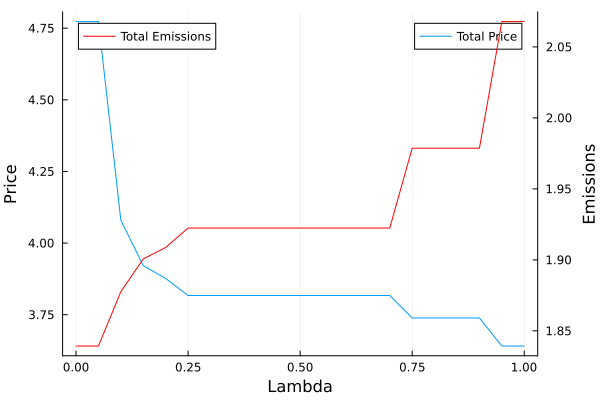

In [17]:
using Plots

# Assuming results_df is your DataFrame with the columns Lambda, Total_Price, and Total_Emissions
lambda = results_df[:, "Lambda"]
total_price = results_df[:, "Total_Price"]
total_emissions = results_df[:, "Total_Emissions"]

# Create a plot with two y-axes
plot(lambda, total_price, label="Total Price", xlabel="Lambda", ylabel="Price", legend=:topright)
plot!(twinx(), lambda, total_emissions, label="Total Emissions", color=:red, ylabel="Emissions")
